FACTOR INVESTING FOR VENTURE CAPITALISTS

Author: [@sparshsah](https://github.com/sparshsah)

In [122]:
from typing import Final, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.linear_model

# https://github.com/sparshsah/foggy-statslib/blob/main/foggy_statslib/core.py
import foggy_statslib.core as fsc

# DATA

## Sample PCA

In [54]:
def _get_pc_mults(
    X: pd.DataFrame,
    var_frac: float | None =  0.80,
) -> pd.DataFrame:
    """Get principal-component multipliers."""
    fitter = sklearn.decomposition.PCA(
        n_components=var_frac,
    )
    fitted = fitter.fit(X)
    mults = pd.DataFrame(
        fitted.components_,
        index=[
            f"pc{i}"
            for i in range(
                1,
                fitted.components_.shape[0] + 1,
            )
        ],
        columns=X.columns,
    )
    return mults


def _calc_pc(
    X: pd.DataFrame,
    mult: pd.Series,
) -> pd.Series:
    if not X.columns.equals(
        mult.index
    ):
        raise ValueError(
            "Misaligned index"
            + f": {list(X.columns)}"
            + f", {list(mult.index)}!"
        )
    X_multed = X * mult
    pc = X_multed.sum(axis="columns")
    assert X.index.equals(
        pc.index
    )
    return pc


def calc_pcs(
    X: pd.DataFrame,
    mults: pd.DataFrame,
) -> pd.DataFrame:
    """Get principal components."""
    pcs = pd.DataFrame(
        {
            i: _calc_pc(
                X=X,
                mult=mult,
            )
            for (i, mult)
            in mults.iterrows()
        }
    )
    assert X.index.equals(
        pcs.index
    )
    return pcs

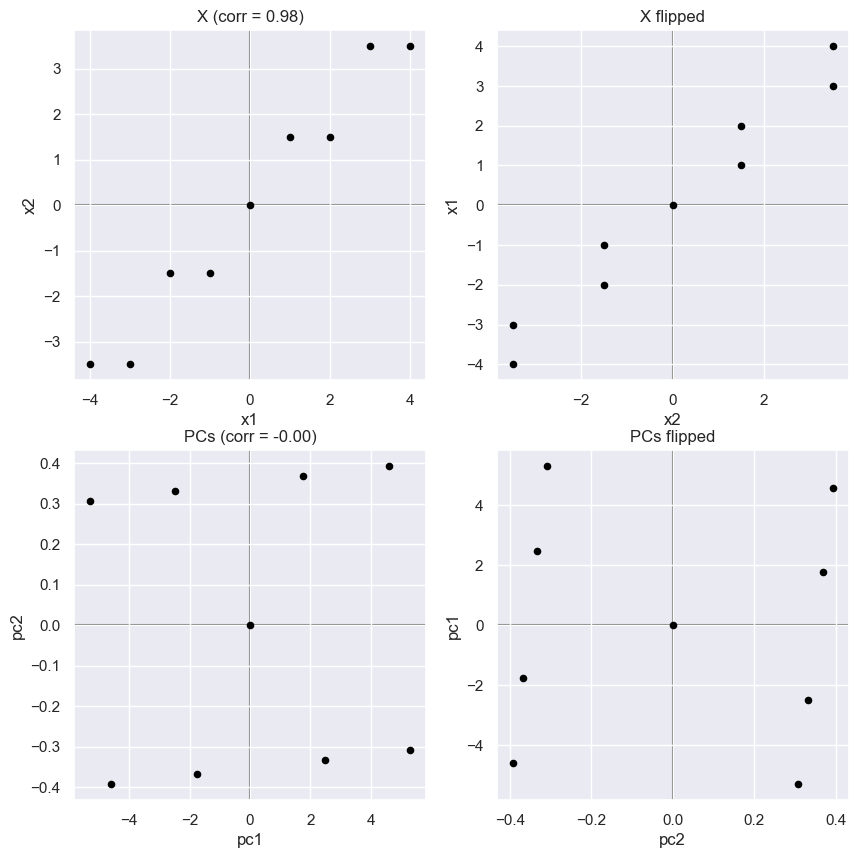

In [64]:
X_train = pd.DataFrame(
    {
        "x1": [-4  , -3  , -2  , -1  , 0, +1  , +2  , +3  , +4  ],
        "x2": [-3.5, -3.5, -1.5, -1.5, 0, +1.5, +1.5, +3.5, +3.5],
    }
)

pc_mults = _get_pc_mults(
    X=X_train,
    var_frac=None,
)
pcs_train = calc_pcs(
    X=X_train,
    mults=pc_mults,
)


_, axs = plt.subplots(
    nrows=2,
    ncols=2,
)
####
fsc.plot(
    X_train,
    kind="scatter",
    axvline_locs=[0],
    title=f"""X (corr = {X_train.corr().loc["x1", "x2"] :.2f})""",
    ax=axs[0, 0],
)
fsc.plot(
    X_train[["x2", "x1"]],
    kind="scatter",
    axvline_locs=[0],
    title=f"""X flipped""",
    ax=axs[0, 1],
)
##
fsc.plot(
    pcs_train,
    kind="scatter",
    axvline_locs=[0],
    title=f"""PCs (corr = {pcs_train.corr().loc["pc1", "pc2"] :.2f})""",
    ax=axs[1, 0],
)
fsc.plot(
    pcs_train[["pc2", "pc1"]],
    kind="scatter",
    axvline_locs=[0],
    title=f"""PCs flipped""",
    ax=axs[1, 1],
    figsize=(10, 10),
)
####
plt.show()

## Actual Data

In [110]:
N_QUARTERS: Final[int] = 4

N_TICKERS: Final[int] = 500
N_ASSETCLASSES: Final[int] = 4
N_COUNTRIES: Final[int] = 5
N_SECTORS: Final[int] = 5
# 5 tickers per sector
N_TICKERS_PER_SECTOR: Final[int] = int(
    N_TICKERS
    / N_ASSETCLASSES
    / N_COUNTRIES
    / N_SECTORS
)
assert N_TICKERS_PER_SECTOR == 5, N_TICKERS_PER_SECTOR

# # debug
# N_QUARTERS: Final[int] = 2
# N_TICKERS: Final[int] = 16
# N_ASSETCLASSES: Final[int] = 2
# N_COUNTRIES: Final[int] = 2
# N_SECTORS: Final[int] = 2
# # 2 tickers per sector
# assert N_TICKERS_PER_SECTOR == 2, N_TICKERS_PER_SECTOR

In [157]:
# index
ix__q = (
    sum(
        (
            [f"q{q}"] * N_TICKERS
            for q in range(1, N_QUARTERS+1)
        ),
        start=[],
    )
)
ix__ticker = (
    [
        f"ticker{t}"
        for t in range(1, N_TICKERS+1)
    ]
    * N_QUARTERS
)

ix = pd.MultiIndex.from_frame(
    pd.DataFrame(
        {
            "q": ix__q,
            "ticker": ix__ticker,
        }
    )
)
del ix__ticker, ix__q


ix

MultiIndex([('q1',   'ticker1'),
            ('q1',   'ticker2'),
            ('q1',   'ticker3'),
            ('q1',   'ticker4'),
            ('q1',   'ticker5'),
            ('q1',   'ticker6'),
            ('q1',   'ticker7'),
            ('q1',   'ticker8'),
            ('q1',   'ticker9'),
            ('q1',  'ticker10'),
            ...
            ('q4', 'ticker491'),
            ('q4', 'ticker492'),
            ('q4', 'ticker493'),
            ('q4', 'ticker494'),
            ('q4', 'ticker495'),
            ('q4', 'ticker496'),
            ('q4', 'ticker497'),
            ('q4', 'ticker498'),
            ('q4', 'ticker499'),
            ('q4', 'ticker500')],
           names=['q', 'ticker'], length=2000)

In [161]:
# qualitative features
XNAMES_QUAL: Final[Sequence[str]] = [
    "ac",
    "ccy",
    "sector",
]

x__ac = (
    sum(
        (
            [f"_ac{a}"] * int(N_TICKERS/N_ASSETCLASSES)
            for a in range(1, N_ASSETCLASSES+1)
        ),
        start=[],
    )
    * N_QUARTERS
)
x__ccy = (
    sum(
        (
        
            [f"_ccy{s}"] * int(N_TICKERS/N_ASSETCLASSES/N_COUNTRIES)
            for s in range(1, N_COUNTRIES+1)
        ),
        start=[],
    )
    * N_ASSETCLASSES
    * N_QUARTERS
)
x__sector = (
    sum(
        (
        
            [f"_sector{s}"] * int(N_TICKERS/N_ASSETCLASSES/N_COUNTRIES/N_SECTORS)
            for s in range(1, N_SECTORS+1)
        ),
        start=[],
    )
    * N_COUNTRIES
    * N_ASSETCLASSES
    * N_QUARTERS
)

_dta_qual = pd.DataFrame(
    {
        "q": ix.map(lambda q_ticker: q_ticker[0]),
        "ac": x__ac,
        "ccy": x__ccy,
        "sector": x__sector,
    },
    index=ix,
)
del x__sector, x__ccy, x__ac
dta_qual = _dta_qual.sum(axis="columns")


dta_qual

q   ticker   
q1  ticker1      q1_ac1_ccy1_sector1
    ticker2      q1_ac1_ccy1_sector1
    ticker3      q1_ac1_ccy1_sector1
    ticker4      q1_ac1_ccy1_sector1
    ticker5      q1_ac1_ccy1_sector1
                        ...         
q4  ticker496    q4_ac4_ccy5_sector5
    ticker497    q4_ac4_ccy5_sector5
    ticker498    q4_ac4_ccy5_sector5
    ticker499    q4_ac4_ccy5_sector5
    ticker500    q4_ac4_ccy5_sector5
Length: 2000, dtype: object

In [162]:
# quantitative features
XNAMES_QUANT: Final[Sequence[str]] = [
    "v",
    "m",
    "c",
    "d",
]

_dta_quant = pd.DataFrame(
    {
        "v": [-8, -2,  0, +2, +8],
        "m": [+1,  0,  0,  0, -1],
        "c": [+1, -1, +1, -1, +1],
        "d": [-2, +1, +1, -2, -4],
    }
)
assert len(_dta_quant) == N_TICKERS_PER_SECTOR, len(dta_quant)
_dta_quant = pd.concat(
    [_dta_quant] * int(N_TICKERS / len(_dta_quant)) * N_QUARTERS,
    ignore_index=True,
).set_index(ix)

# rank-stdize
dta_quant = (
    _dta_quant
    .groupby(dta_qual)
    .rank()
)

dta_quant

v    m    c    d
q  ticker                       
q1 ticker1    1.0  5.0  4.0  2.5
   ticker2    2.0  3.0  1.5  4.5
   ticker3    3.0  3.0  4.0  4.5
   ticker4    4.0  3.0  1.5  2.5
   ticker5    5.0  1.0  4.0  1.0
...           ...  ...  ...  ...
q4 ticker496  1.0  5.0  4.0  2.5
   ticker497  2.0  3.0  1.5  4.5
   ticker498  3.0  3.0  4.0  4.5
   ticker499  4.0  3.0  1.5  2.5
   ticker500  5.0  1.0  4.0  1.0

[2000 rows x 4 columns]

In [164]:
_y = np.sign(
    dta_quant
    .sum(axis="columns")
)


# flip sign w.p. 0.10
is_flip = (
    np.random
    .default_rng(seed=42)
    .choice(
        a=[1   , -1  ],
        p=[0.90, 0.10],
        size=len(ix)
    )
)
y = _y * is_flip
del is_flip
y = (np.sign(y) > 0).astype(int)


y

q   ticker   
q1  ticker1      1
    ticker2      1
    ticker3      1
    ticker4      1
    ticker5      1
                ..
q4  ticker496    1
    ticker497    1
    ticker498    1
    ticker499    1
    ticker500    1
Length: 2000, dtype: int64

In [118]:
dta_quant.drop(index="q-4")

v  m  c  d
q   ticker                
q-1 ticker-1   -8  1  1 -2
    ticker-2   -2  0 -1  1
    ticker-3    0  0  1  1
    ticker-4    2  0 -1 -2
    ticker-5    8 -1  1 -4
...            .. .. .. ..
q-3 ticker-496 -8  1  1 -2
    ticker-497 -2  0 -1  1
    ticker-498  0  0  1  1
    ticker-499  2  0 -1 -2
    ticker-500  8 -1  1 -4

[1500 rows x 4 columns]

In [129]:
dta_quant.loc[["q-4"], :]

v  m  c  d
q   ticker                
q-4 ticker-1   -8  1  1 -2
    ticker-2   -2  0 -1  1
    ticker-3    0  0  1  1
    ticker-4    2  0 -1 -2
    ticker-5    8 -1  1 -4
...            .. .. .. ..
    ticker-496 -8  1  1 -2
    ticker-497 -2  0 -1  1
    ticker-498  0  0  1  1
    ticker-499  2  0 -1 -2
    ticker-500  8 -1  1 -4

[500 rows x 4 columns]